In [1]:
import pandas as pd
import numpy as np

import sys
import os

from pathlib import Path
# librosa is a Python library for analyzing audio and music. It can be used to extract the data from the audio files we will see it later.
import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder, normalize
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

# to play the audio files
from IPython.display import Audio

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)

## Data Loading


In [10]:
# emofilm_info_df = pd.read_csv('D:/Documents/emofilm/data/complete_info.csv')
emofilm_uk_df = pd.read_csv('D:/Documents/emofilm/data/emofilm_uk_df.csv')
emofilm_df = pd.read_csv('D:/Documents/emofilm_df.csv')
ravdess_df = pd.read_csv('D:/Documents/ravdess_df.csv')
cremad_df = pd.read_csv('D:/Documents/cremad_df.csv')

In [11]:
data_df = pd.concat([emofilm_df, emofilm_uk_df, ravdess_df, cremad_df],
                    axis=0, ignore_index=True)

data_df_no_uk = pd.concat([emofilm_df, ravdess_df, cremad_df],
                          axis=0, ignore_index=True)

In [12]:
data_df_no_uk.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9997 entries, 0 to 9996
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   emotion  9997 non-null   object
 1   path     9997 non-null   object
dtypes: object(2)
memory usage: 156.3+ KB


In [13]:
emotions = data_df.emotion.unique().tolist()
emotions_number = len(emotions)
print(emotions, emotions_number)

['fear', 'contempt', 'happiness', 'anger', 'sadness', 'neutral', 'calm', 'surprise'] 8


In [14]:
def load_features(path, shape):
    df = pd.read_csv(path)
    print(df.info())

    labels = df['labels']
    features = df.drop(columns=['labels']).to_numpy()
    features = features.reshape(shape)
    return [features, labels]

In [16]:
train_features_e, train_labels_decoded = load_features(
    './features/features-train-all-2d-v3.csv', (27936, 128, 87, 1))
test_features_e, test_labels_decoded = load_features(
    './features/features-test-all-2d-v3.csv', (1597, 128, 87, 1))
val_features_e, val_labels_decoded = load_features(
    './features/features-val-all-2d-v3.csv', (2394, 128, 87, 1))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27936 entries, 0 to 27935
Columns: 11137 entries, 0 to labels
dtypes: float64(11136), object(1)
memory usage: 2.3+ GB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1597 entries, 0 to 1596
Columns: 11137 entries, 0 to labels
dtypes: float64(11136), object(1)
memory usage: 135.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2394 entries, 0 to 2393
Columns: 11137 entries, 0 to labels
dtypes: float64(11136), object(1)
memory usage: 203.4+ MB
None


In [17]:
encoder = OneHotEncoder()
train_labels = encoder.fit_transform(
    np.array(train_labels_decoded).reshape(-1, 1)).toarray()
test_labels = encoder.fit_transform(
    np.array(test_labels_decoded).reshape(-1, 1)).toarray()
val_labels = encoder.fit_transform(
    np.array(val_labels_decoded).reshape(-1, 1)).toarray()

In [18]:
max_length = 110250
max_i = 14
sample_rate = 22050
max_duration_s = librosa.get_duration(path=data_df['path'][14])
required_duration_millis = 5000

width = 216  # 5 seconds of adio is 216
height = 128  # melspectrogram height is 128

duration = int(required_duration_millis/1000*sample_rate)

width_3s = int(3*sample_rate)

In [10]:
# # scaling our data with sklearn's Standard scaler
# scaler = StandardScaler()
# x_train = scaler.fit_transform(x_train)
# x_test = scaler.transform(x_test)
# print(
#     f'train:\t {x_train.shape, y_train.shape,}\ntest:\t{x_test.shape, y_test.shape}')

## Modeling


In [19]:
import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, AveragePooling2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.utils import Sequence, to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

os.environ["TF_MIN_GPU_MULTIPROCESSOR_COUNT"] = "2"
os.environ["CUDA_VISIBLE_DEVICES"] = "0,2"
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [20]:
# https://stackoverflow.com/questions/62916904/failed-copying-input-tensor-from-cpu-to-gpu-in-order-to-run-gatherve-dst-tensor
# Fernando Wittmann

class DataGenerator(Sequence):

    def __init__(self, x_set, y_set, batch_size):

        self.x, self.y = x_set, y_set

        self.batch_size = batch_size

    def __len__(self):

        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def __getitem__(self, idx):

        batch_x = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]

        batch_y = self.y[idx * self.batch_size:(idx + 1) * self.batch_size]

        return batch_x, batch_y


train_gen = DataGenerator(train_features_e, train_labels, 32)


val_gen = DataGenerator(val_features_e, val_labels, 32)

### main


In [21]:
train_features_e[0].shape

(128, 87, 1)

In [40]:
input_shape = train_features_e[0].shape
# input_shape = (128, 87, 1)
CNNmodel = Sequential()
CNNmodel.add(Conv2D(32, 7, activation='relu',
             input_shape=input_shape, padding='same'))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Conv2D(96, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(96, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(96, 3, activation='relu', padding='same'))
CNNmodel.add(Dropout(0.3))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(128, 3, activation='relu', padding='same'))
CNNmodel.add(MaxPooling2D((2, 2)))
CNNmodel.add(Dropout(0.3))
CNNmodel.add(Conv2D(160, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(160, 3, activation='relu', padding='same'))
CNNmodel.add(Conv2D(160, 3, activation='relu', padding='same'))
CNNmodel.add(AveragePooling2D((2, 2)))
CNNmodel.add(Flatten())
CNNmodel.add(Dropout(0.3))
CNNmodel.add(Dense(32, activation='relu'))
CNNmodel.add(Dense(32, activation='relu'))
CNNmodel.add(Dense(units=emotions_number, activation='softmax'))

CNNmodel.compile(optimizer='adam',
                 loss='categorical_crossentropy', metrics=['accuracy'])

CNNmodel.summary()

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_116 (Conv2D)         (None, 128, 87, 32)       1600      
                                                                 
 max_pooling2d_49 (MaxPoolin  (None, 64, 43, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_117 (Conv2D)         (None, 64, 43, 96)        27744     
                                                                 
 conv2d_118 (Conv2D)         (None, 64, 43, 96)        83040     
                                                                 
 conv2d_119 (Conv2D)         (None, 64, 43, 96)        83040     
                                                                 
 dropout_32 (Dropout)        (None, 64, 43, 96)        0         
                                                     

In [41]:
rlrp = ReduceLROnPlateau(monitor='loss', factor=0.4,
                         verbose=0, patience=2, min_lr=0.0000001)

history = CNNmodel.fit(train_gen,
                       epochs=20,
                       validation_data=val_gen,
                       callbacks=[rlrp])

Epoch 1/20
873/873 [==============================] - 116s 130ms/step - loss: 1.8405 - accuracy: 0.2534 - val_loss: 1.6899 - val_accuracy: 0.3074 - lr: 0.0010
Epoch 2/20
625/873 [====================>.........] - ETA: 31s - loss: 1.6509 - accuracy: 0.3503

KeyboardInterrupt: 

In [25]:
def print_report(model, history, test_x, test_y):
    print("Accuracy of our model on test data : ",
          model.evaluate(test_x, test_y)[1]*100, "%")

    epochs = history.epoch

    fig, ax = plt.subplots(1, 2)

    train_acc = history.history['accuracy']
    train_loss = history.history['loss']
    test_acc = history.history['val_accuracy']
    test_loss = history.history['val_loss']

    fig.set_size_inches(20, 6)
    ax[0].plot(epochs, train_loss, label='Training Loss')
    ax[0].plot(epochs, test_loss, label='Testing Loss')
    ax[0].set_title('Training & Testing Loss')
    ax[0].legend()
    ax[0].set_xlabel("Epochs")
    ax[1].plot(epochs, train_acc, label='Training Accuracy')
    ax[1].plot(epochs, test_acc, label='Testing Accuracy')
    ax[1].set_title('Training & Testing Accuracy')
    ax[1].legend()
    ax[1].set_xlabel("Epochs")

    plt.show()

50/50 [==============================] - 1s 27ms/step - loss: 1.2281 - accuracy: 0.5811
Accuracy of our model on test data :  58.10895562171936 %


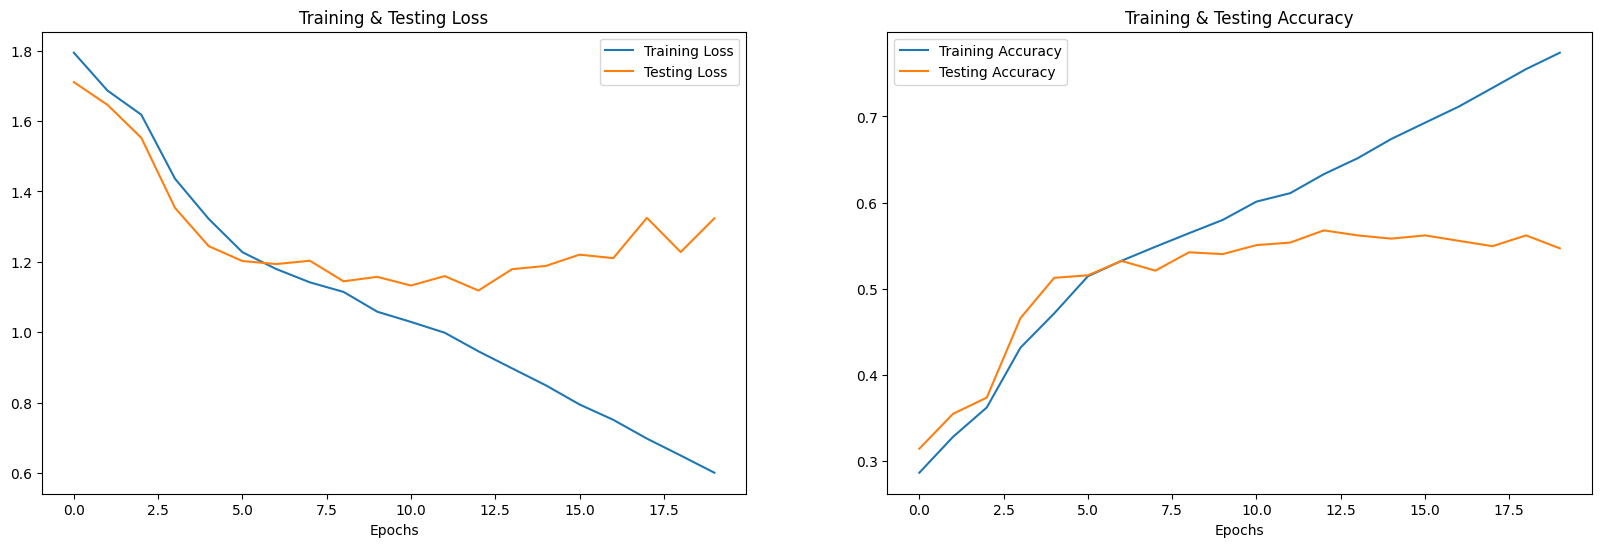

In [26]:
print_report(CNNmodel, history, test_features_e, test_labels)

In [27]:
# predicting on test data.
y_pred = CNNmodel.predict(test_features_e)

y_pred_decoded = encoder.inverse_transform(y_pred)
# y_test_decoded = encoder.inverse_transform(test_labels)

50/50 [==============================] - 1s 14ms/step


In [28]:
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred_decoded.flatten()
df['Actual Labels'] = test_labels_decoded

df.head(10)

,Predicted Labels,Actual Labels
0,happiness,happiness
1,happiness,happiness
2,anger,anger
3,contempt,contempt
4,neutral,contempt
5,fear,neutral
6,fear,fear
7,contempt,contempt
8,surprise,surprise
9,anger,happiness


In [29]:
def print_confusion_matrix(test, pred, size=(12, 10)):
    cm = confusion_matrix(test, pred)
    plt.figure(figsize=size)
    cm = pd.DataFrame(cm, index=[i for i in encoder.categories_], columns=[
        i for i in encoder.categories_])
    sns.heatmap(cm, linecolor='white', cmap='Blues',
                linewidth=1, annot=True, fmt='')
    plt.title('Confusion Matrix', size=20)
    plt.xlabel('Predicted Labels', size=14)
    plt.ylabel('Actual Labels', size=14)
    plt.show()

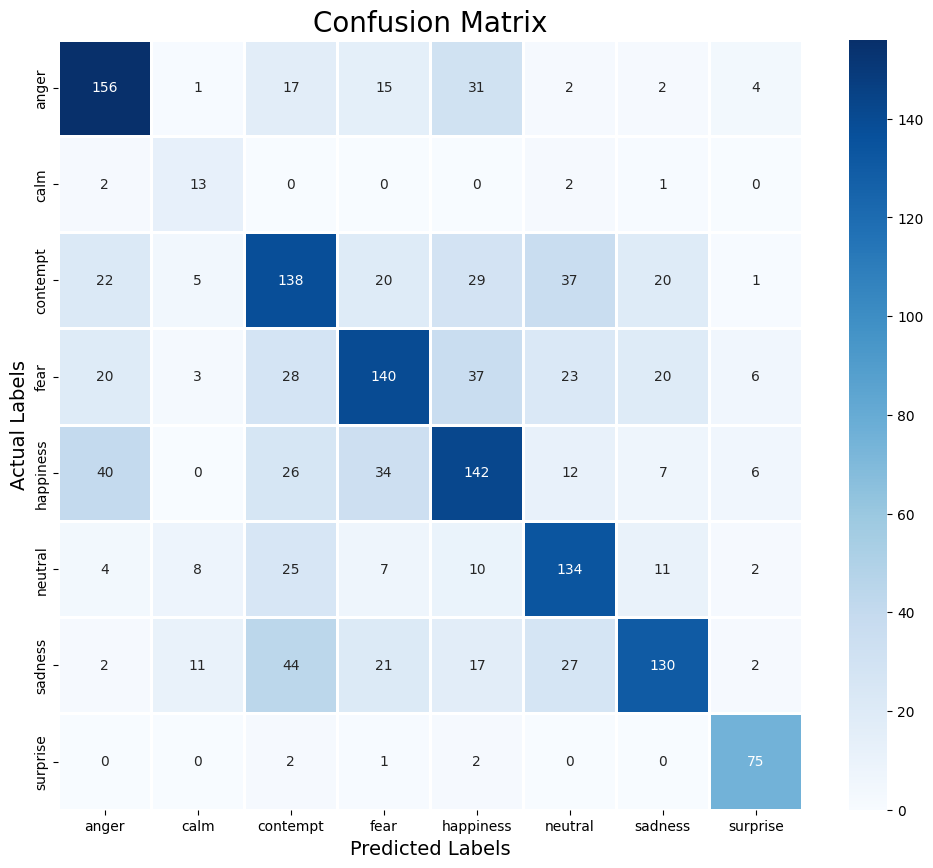

In [30]:
print_confusion_matrix(test_labels_decoded, y_pred_decoded)

In [31]:
print(classification_report(test_labels_decoded, y_pred_decoded))

              precision    recall  f1-score   support

       anger       0.63      0.68      0.66       228
        calm       0.32      0.72      0.44        18
    contempt       0.49      0.51      0.50       272
        fear       0.59      0.51      0.54       277
   happiness       0.53      0.53      0.53       267
     neutral       0.57      0.67      0.61       201
     sadness       0.68      0.51      0.58       254
    surprise       0.78      0.94      0.85        80

    accuracy                           0.58      1597
   macro avg       0.57      0.63      0.59      1597
weighted avg       0.59      0.58      0.58      1597

